In [1]:
import numpy as np
import pandas as pd
import math
import json
import sys
import time

### data manipulation

In [2]:
def readFiles(filename):
    df = pd.read_csv(filename, header=None)
    
    # restrictions are in first row
    restr = pd.to_numeric(df.iloc[0])
    
    # drop metadata columns
    df = df.drop([0], axis=0)
    
    return df, restr

In [3]:
def restrictdf(df, restr, setIndex=False, getDropped=False):
    # remove restricted cols and convert to numeric
    dropped=pd.DataFrame()
    for i, v in enumerate(df.columns):
        if restr[i] == 0 and setIndex:
            df = df.set_index(df.columns[i])
        elif restr[i] < 1:
            dropped[v] = df[v]
            df = df.drop(columns=[v])
        else:
            df[v] = pd.to_numeric(df[v], errors='coerce')
            
    # drop unknown values
    df = df.dropna()
    df = df[(df != '?').all(axis=1)]
    if getDropped:
        return df, dropped
    return df

In [4]:
# normalizes all columns
def normalizedf(indf):
    df=indf.copy()
    for c in df.columns:
        colMax = df[c].max()
        colMin = df[c].min()
        
        # probably no need to normalize if the values are very small. Might have to adjust the value
#         if colMax < 1:
#             continue
        df[c] = df[c].apply(lambda x: (x - colMin)/(colMax-colMin))
    return df

### helper functions

In [5]:
def euclideanDist(point, pointArray):
    return np.sqrt(np.sum((pointArray - point) ** 2, axis=1))

In [19]:
def initCentroids_random(numdf, k):
    if k>=len(numdf):
        print('k cannot be bigger than the length of data')
        exit(1)
    sample=np.array(numdf.sample(k))
    while len(np.unique(sample)) < k:
        sample=np.array(numdf.sample(k))
    return sample


In [20]:
def calcCentroid(dfarray):
    return np.divide(np.sum(dfarray, axis=0),len(dfarray))

In [43]:
def initCentroids_max(indf, k, distFunc):
    if indf.columns[-1] == 'cluster':
        numdf = indf.drop('cluster')
    else:
        numdf=indf.copy()
    
    dfarray = np.array(numdf)
    c = calcCentroid(dfarray)
    centroids=[]
    centroids.append(np.array(numdf.iloc[np.argmax(distFunc(c, dfarray))]))
    for i in range(k-1):
        sumdist = None
        for c in centroids:
            if sumdist is None:
                sumdist = distFunc(c, dfarray)
            else:
                sumdist = np.add(sumdist, distFunc(c, dfarray))
        centroids.append(np.array(numdf.iloc[np.argmax(sumdist)]))
    return centroids

In [8]:
# pass a ***vectorized*** distance function: dist(point, pointArray)
# dataframe must be numeric other than last column
def assignCentroids(numdf, centroids, distfunc, getNumAssign = False):
    if df.columns[-1] != 'cluster':
        df['cluster'] = -1
    numAssign=0
    for i, row in df.iloc[:,:-1].iterrows():
        prev = df.at[i,'cluster']
        new = np.argmin(distfunc(row.values, centroids))
        if prev != new:
            numAssign += 1
        df.at[i,'cluster'] = new
    if getNumAssign:
        return df, numAssign
    return df

In [9]:
def reCalcCentroids(numdf, centroids):
    # centroid index is tag
    for i in range(len(centroids)):
        cluster = numdf[numdf['cluster'] == i]
        centroids[i] = np.mean(np.array(cluster.iloc[:,:-1]), axis=0)
    return centroids

In [10]:
def calcSSE(dfarray, c, distFunc):
    return np.sum(np.square(distFunc(c, dfarray)))

In [11]:
# takes labeled numeric df
def calcTotSSE(numdf, centroids, distFunc):
    totSSE=None
    for i, c in enumerate(centroids):
        cSSE = calcSSE(np.array(numdf[numdf['cluster'] == i].iloc[:,:-1]), c, distFunc)
        if totSSE is None:
            totSSE = cSSE
        else:
            totSSE += cSSE
    return totSSE

### kmeans 

In [12]:
def kmeans_sse(df, centroids, distFunc, minSSE):
    df = assignCentroids(df, centroids, distFunc)
    prevSSE = calcTotSSE(df, centroids, distFunc)
    
    centroids = reCalcCentroids(df, centroids)
    df = assignCentroids(df, centroids, distFunc)
    currSSE = calcTotSSE(df, centroids, distFunc)
    print(f"current sse: {currSSE}")
    
    counter = 0
    while counter < 10 and prevSSE - currSSE > minSSE:
        centroids = reCalcCentroids(df, centroids)
        df = assignCentroids(df, centroids, distFunc)
        prevSSE = currSSE
        currSSE = calcTotSSE(df, centroids, distFunc)
        print(f"current sse: {currSSE}")
        
        counter += 1
    return df, centroids

In [13]:
def kmeans_reassign(df, centroids, distFunc, minReassign):
    df, numAssign = assignCentroids(df, centroids, distFunc, getNumAssign=True)
    print(f"{numAssign} points reassigned")
    
    centroids = reCalcCentroids(df, centroids)
    df, numAssign = assignCentroids(df, centroids, distFunc, getNumAssign=True)
    print(f"{numAssign} points reassigned")
    
    counter = 0
    while counter < 100 and numAssign > minReassign:
        centroids = reCalcCentroids(df, centroids)
        df, numAssign = assignCentroids(df, centroids, distFunc, getNumAssign=True)
        print(f"{numAssign} points reassigned")
        counter += 1
    return df, centroids

### analytical functions

In [14]:
# takes numeric df with cluster labe
def analyzeClusters(df, centroids, distFunc, extraCols = None):
    clusters=[]
    for i, c in enumerate(centroids):
        info = {}
        info["clusterID"] = i
        pnts = df[df['cluster'] == i]
        if len(pnts) == 0:
            continue
        
        info["SSE"] = calcSSE(np.array(pnts.iloc[:,:-1]), c, distFunc)
        info["centroid"] = c
        
        dists = distFunc(c, np.array(pnts.iloc[:,:-1]))
        info["maxDistToCentroid"] = max(dists)
        info["minDistToCentroid"] = min(dists)
        info["avgDistToCentroid"] = np.sum(dists)/len(pnts)
        info["numPoints"] = len(pnts)
        if extraCols is not None:
            pnts = pnts.join(extraCols)
        info["dataPoints"] = pnts
        clusters.append(info)
    return clusters

In [15]:
def printClusterInfo(clusters, noData=False):
    for clusterInfo in clusters:
        for key in clusterInfo:
            if key == "dataPoints":
                if not noData:
                    print(f"{key}: \n{clusterInfo[key].to_markdown()}")
            else:
                print(f"{key}: {clusterInfo[key]}")
        print('\n')

### running

In [16]:
# k=4

# sys.argv = f"dbscan.py ./data/4clusters.csv {k}".split(" ")
# if __name__ == "__main__":
#     if len(sys.argv) == 3:
#         _, datafile, k = sys.argv
#     else:
#         print("Usage: python3 dbscan.py <datafile.csv> <epsilon> <numPoints>")
#         exit(1)
        
#     k = int(k)
#     df_full, restr = readFiles(datafile)
#     df = restrictdf(df_full, restr, getDropped=True)
#     df = df
#     centroids = initCentroids(df,k)
#     df, centroids = kmeans_lite(df, centroids, euclideanDist)
#     df.plot.scatter(x=0,y=1,c='cluster',colormap='viridis')    
# #     print(dropped)
# #     df = df.join(dropped)
# #     print(df.to_markdown())
#     printClusterInfo(analyzeClusters(df, centroids, euclideanDist), extraCols = dropped)

### Iris

In [17]:
def calcPurity(col):
    vals = col.value_counts()
    return max(vals)/len(col)

current sse: 118.92636096938779
current sse: 86.03620408163268
current sse: 84.35467300347221
current sse: 83.47963263888887
current sse: 82.09358738904194
current sse: 81.17033414092327
current sse: 79.96297983461301
current sse: 79.43376414532673
current sse: 79.01070972222222
current sse: 78.9450658259773

purity of cluster 0: 1.0
purity of cluster 1: 0.9230769230769231
purity of cluster 2: 0.7704918032786885
mean purity: 0.8978562421185372

clusterID: 0
SSE: 25.413846153846155
centroid: [6.85384615 3.07692308 5.71538462 2.05384615]
maxDistToCentroid: 1.5515596276348875
minDistToCentroid: 0.23945203717343622
avgDistToCentroid: 0.7318458783535899
numPoints: 39


clusterID: 1
SSE: 38.29081967213115
centroid: [5.88360656 2.74098361 4.38852459 1.43442623]
maxDistToCentroid: 1.6468010735564589
minDistToCentroid: 0.23571239518479192
avgDistToCentroid: 0.7311084910642591
numPoints: 61


clusterID: 2
SSE: 15.2404
centroid: [5.006 3.418 1.464 0.244]
maxDistToCentroid: 1.2393514432960495
minD

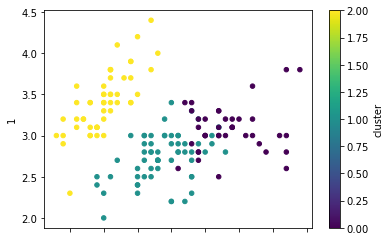

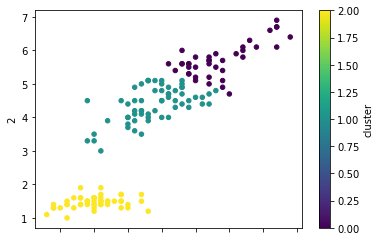

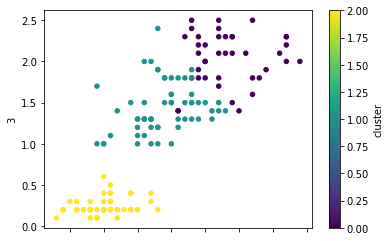

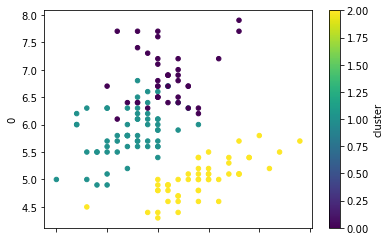

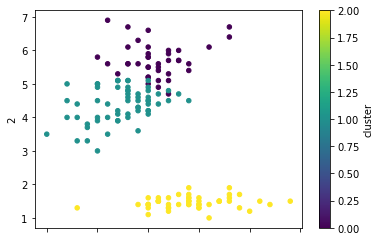

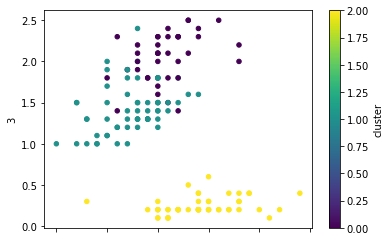

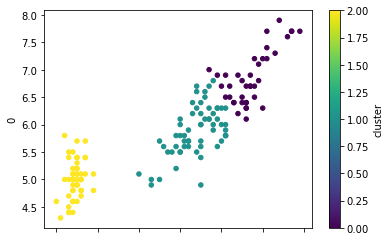

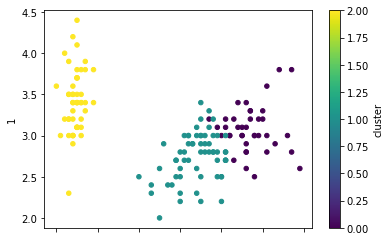

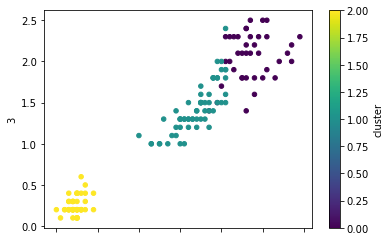

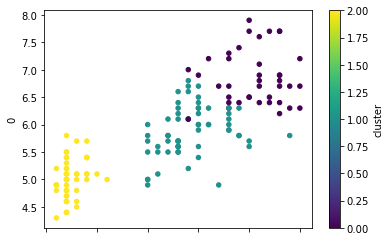

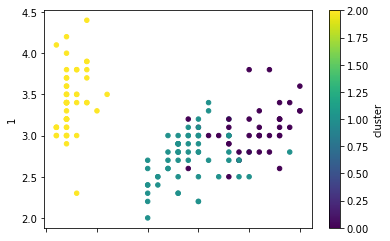

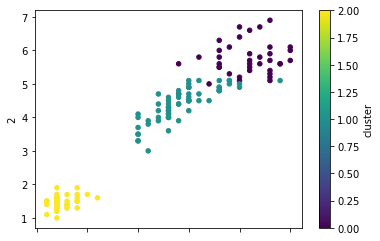

In [149]:
df_full, restr = readFiles('./data/iris.csv')
df,dropped = restrictdf(df_full, restr, getDropped=True)

# centroids = initCentroids_max(df, 3, euclideanDist)
centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 0.3)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)
print()
sumpurity=0
for c in clusters:
    pur = calcPurity(pnts.iloc[:,-1])
    sumpurity += pur
    pnts = c["dataPoints"]
    print(f"purity of cluster {c['clusterID']}: {pur}")
print(f"mean purity: {sumpurity/len(clusters)}")
print()
printClusterInfo(clusters, noData=True)
for i in range(4):
    for j in range(4):
        if i != j:
            df.plot.scatter(x=i,y=j,c='cluster',colormap='viridis')    

### 4clusters

current sse: 1663.7096875
current sse: 1584.9876543209875
current sse: 1554.7743055555554

clusterID: 0
SSE: 1164.111111111111
centroid: [33.16666667 17.27777778]
maxDistToCentroid: 12.124101086698913
minDistToCentroid: 2.2838671990104937
avgDistToCentroid: 7.579450143514094
numPoints: 18


clusterID: 1
SSE: 233.21875000000003
centroid: [12.875 39.25 ]
maxDistToCentroid: 12.189262693042595
minDistToCentroid: 0.7603453162872774
avgDistToCentroid: 4.980787048467772
numPoints: 6


clusterID: 2
SSE: 86.44444444444443
centroid: [41.11111111 41.77777778]
maxDistToCentroid: 4.275973645531965
minDistToCentroid: 0.7856742013183874
avgDistToCentroid: 2.9117006199139848
numPoints: 9


clusterID: 3
SSE: 71.0
centroid: [10. 35.]
maxDistToCentroid: 5.0
minDistToCentroid: 1.4142135623730951
avgDistToCentroid: 3.2141158591734738
numPoints: 6




<AxesSubplot:xlabel='0', ylabel='1'>

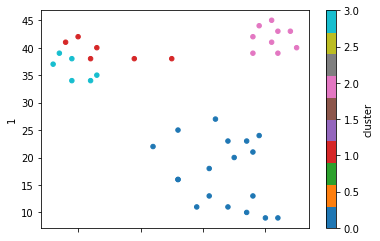

In [152]:
df_full, restr = readFiles('./data/4clusters.csv')
df = restrictdf(df_full, restr)

centroids = initCentroids_max(df, 4, euclideanDist)
# centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 50)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)

print()
printClusterInfo(clusters, noData=True)
df.plot.scatter(x=0,y=1,c='cluster', colormap='tab10')    

### many clusters

current sse: 2794.0810068899355
current sse: 2461.4020421580867
current sse: 2220.357575757576
current sse: 2164.5409090909093
current sse: 2164.5409090909093

clusterID: 0
SSE: 223.16666666666669
centroid: [10.58333333  6.75      ]
maxDistToCentroid: 8.087198388674398
minDistToCentroid: 0.4859126579037745
avgDistToCentroid: 3.6192788200810093
numPoints: 12
dataPoints: 
|    |   0 |   1 |   cluster |
|---:|----:|----:|----------:|
| 54 |   7 |  14 |         0 |
| 57 |  12 |  10 |         0 |
| 58 |  16 |   9 |         0 |
| 59 |   5 |   8 |         0 |
| 61 |   9 |   7 |         0 |
| 62 |  11 |   7 |         0 |
| 64 |  10 |   6 |         0 |
| 65 |  13 |   6 |         0 |
| 68 |   9 |   5 |         0 |
| 69 |  11 |   5 |         0 |
| 71 |  10 |   3 |         0 |
| 73 |  14 |   1 |         0 |


clusterID: 1
SSE: 277.09090909090907
centroid: [41.27272727 38.90909091]
maxDistToCentroid: 10.08558418062448
minDistToCentroid: 1.676280810416891
avgDistToCentroid: 4.396794888519616
numPoin

<AxesSubplot:xlabel='0', ylabel='1'>

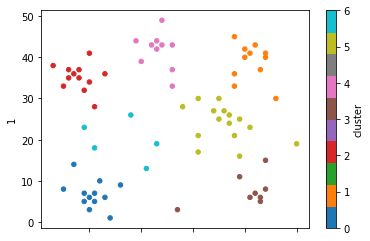

In [160]:
df_full, restr = readFiles('./data/many_clusters.csv')
df = restrictdf(df_full, restr)

centroids = initCentroids_max(df, 7, euclideanDist)
# centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 10)

clusters = analyzeClusters(df, centroids, euclideanDist)

print()
printClusterInfo(clusters)
df.plot.scatter(x=0,y=1,c='cluster', colormap='tab10')    

### mammal milk

In [167]:
df_full, restr = readFiles('./data/mammal_milk.csv')
df,dropped = restrictdf(df_full, restr, getDropped=True)

centroids = initCentroids_max(df, 3, euclideanDist)
# centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 10)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)

print()
for clusterInfo in clusters:
    for key in clusterInfo:
        if key == "dataPoints":
            print(f"{key}: \n{clusterInfo[key].iloc[:,-2:].to_markdown()}")
        else:
            print(f"{key}: {clusterInfo[key]}")
    print('\n')
# df.plot.scatter(x=0,y=1,c='cluster', colormap='tab10') 

current sse: 1463.6307500000003
current sse: 764.45903062963
current sse: 731.1118672433682
current sse: 704.5688687500001
current sse: 704.5688687500001

clusterID: 0
SSE: 27.191200000000013
centroid: [45.65 10.15 38.45  0.45  0.69]
maxDistToCentroid: 3.6872211758992752
minDistToCentroid: 3.6872211758992677
avgDistToCentroid: 3.6872211758992712
numPoints: 2
dataPoints: 
|    |   cluster | 0       |
|---:|----------:|:--------|
| 24 |         0 | Seal    |
| 25 |         0 | Dolphin |


clusterID: 1
SSE: 377.2214687500001
centroid: [86.0625    4.275     4.175     5.11875   0.635625]
maxDistToCentroid: 7.673971556705501
minDistToCentroid: 1.24148175706492
avgDistToCentroid: 4.510754404711805
numPoints: 16
dataPoints: 
|    |   cluster | 0          |
|---:|----------:|:-----------|
|  1 |         1 | Horse      |
|  2 |         1 | Orangutan  |
|  3 |         1 | Monkey     |
|  4 |         1 | Donkey     |
|  5 |         1 | Hippo      |
|  6 |         1 | Camel      |
|  7 |         1 

### accidents 1

### accidents 3